In [1]:
#Libraries
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Dense, Flatten
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping

gen_dir = "/Users/w20009829/OneDrive - Northumbria University - Production Azure AD/Term3/"

#gen_dir = "/Users/xaichotic/Library/CloudStorage/OneDrive-NorthumbriaUniversity-ProductionAzureAD/Term3/"


In [4]:
# pip install numpy

In [7]:
# pip install pandas

In [10]:
# pip install -U scikit-learn

In [13]:
# pip install -U matplotlib

In [3]:
# pip install -U imblearn

In [ ]:
# pip install --user -U tensorflow

In [15]:
# pip install -U seaborn

In [2]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [3]:
#loading the data

data_dir = gen_dir + "Data_ALL/EDA/EDA_csv_files2_labeled_segment6_neurokit/" #using baseline6 EDA

#creating output directory if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

data = []
labels = []
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        filepath = os.path.join(data_dir, filename)
        label = int(filename.split("_")[2].split(".")[0])
        signal_df = pd.read_csv(filepath)
        signal_values = signal_df.to_numpy()
        data.append(signal_values)
        labels.append(label)
        
# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

In [4]:
print(data.shape)
print(labels.shape)

(66, 1439, 1)
(66,)


In [5]:
from imblearn.under_sampling import RandomUnderSampler

# Flatten the data array to a 2D array
data_2d = data.reshape((data.shape[0], -1))

# Print class counts before downsampling
print("Class counts before downsampling:", Counter(labels))

# Random undersampling of the majority class
rus = RandomUnderSampler(random_state=42)
data_resampled, labels_resampled = rus.fit_resample(data_2d, labels)

# Reshape the data array back to the original shape
data_resampled = data_resampled.reshape((data_resampled.shape[0], data.shape[1], data.shape[2]))

# Print class counts after downsampling
print("Class counts after downsampling:", Counter(labels_resampled))

Class counts before downsampling: Counter({0: 47, 1: 19})
Class counts after downsampling: Counter({0: 19, 1: 19})


In [6]:
#just saving it back to data and labels

data = data_resampled
labels = labels_resampled

print(data.shape)
print(labels.shape)

(38, 1439, 1)
(38,)


In [8]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=22)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(30, 1439, 1)
(30,)
(8, 1439, 1)
(8,)


In [10]:
# Z-score normalization for baseline_6
from scipy.stats import zscore

# Normalize the data
X_train = np.array([zscore(x, axis=None) for x in X_train])
X_test = np.array([zscore(x, axis=None) for x in X_test])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(30, 1439, 1)
(30,)
(8, 1439, 1)
(8,)


In [11]:
#Proposed CNN

import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad

# Set a random seed
np.random.seed(123)
tf.random.set_seed(123)

filter_size = 32
kernel_size = 3
nuerons = 128

# Define the CNN model
model = Sequential()
model.add(Conv1D(filter_size, kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPooling1D(2))
model.add(Conv1D(filter_size*2, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPooling1D(2))
model.add(Conv1D(filter_size*4, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(nuerons, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(nuerons*2, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(nuerons*4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))


Epoch 1/20
4/4 [==============================] - 2s 121ms/step - loss: 1.0368 - accuracy: 0.5667 - val_loss: 0.6953 - val_accuracy: 0.5000
Epoch 2/20
4/4 [==============================] - 0s 46ms/step - loss: 1.0423 - accuracy: 0.6000 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 3/20
4/4 [==============================] - 0s 46ms/step - loss: 0.9269 - accuracy: 0.7000 - val_loss: 0.7023 - val_accuracy: 0.5000
Epoch 4/20
4/4 [==============================] - 0s 45ms/step - loss: 0.3959 - accuracy: 0.8000 - val_loss: 0.7156 - val_accuracy: 0.3750
Epoch 5/20
4/4 [==============================] - 0s 46ms/step - loss: 0.2729 - accuracy: 0.8000 - val_loss: 0.6996 - val_accuracy: 0.3750
Epoch 6/20
4/4 [==============================] - 0s 47ms/step - loss: 0.1492 - accuracy: 0.9333 - val_loss: 0.6895 - val_accuracy: 0.2500
Epoch 7/20
4/4 [==============================] - 0s 46ms/step - loss: 0.1565 - accuracy: 0.9000 - val_loss: 0.6938 - val_accuracy: 0.2500
Epoch 8/20
4/4 [==========

1/1 [==============================] - 0s 169ms/step
              precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.33      0.20      0.25         5

    accuracy                           0.25         8
   macro avg       0.27      0.27      0.25         8
weighted avg       0.28      0.25      0.25         8

Confusion matrix:
 [[1 2]
 [4 1]]
ROC-AUC score: 0.4666666666666667


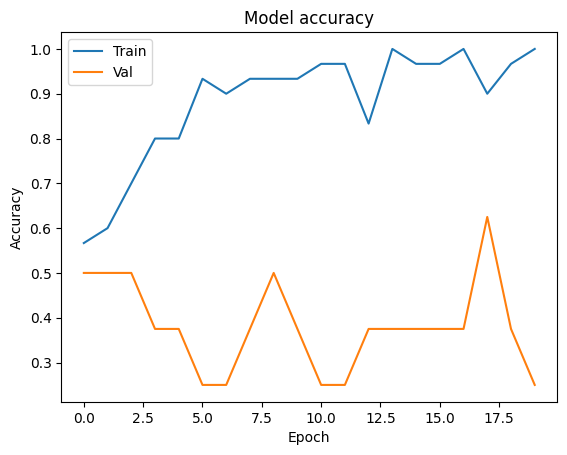

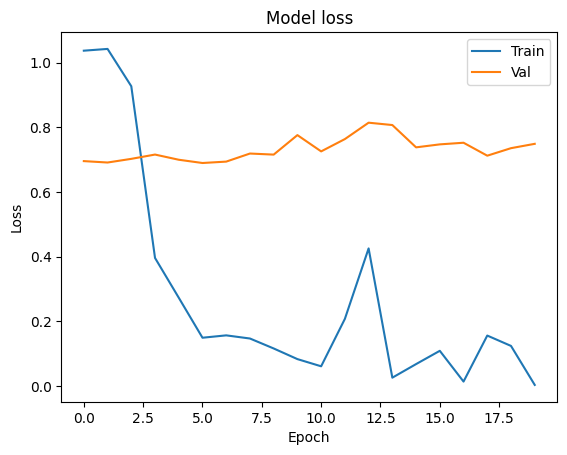

In [12]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred_classes))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print('Confusion matrix:\n', cm)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print('ROC-AUC score:', roc_auc)

# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot the training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [20]:
#gridsearch

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Define the model builder function
def build_model(optimizer='adam', filter_size=64, kernel_size=3, nuerons=32):
    model = Sequential()
    model.add(Conv1D(filter_size, kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filter_size*2, kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filter_size*4, kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(nuerons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(nuerons*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(nuerons*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model with the given optimizer
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Define the grid search parameters
param_grid = {
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'filter_size': [32, 64,128],
    'kernel_size': [3],
    'nuerons': [128]
}

# Instantiate the grid search
grid_search = GridSearchCV(
    estimator=KerasClassifier(build_fn=build_model, epochs=20, batch_size=8, verbose=0),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5)

# Fit the grid search to the data
grid_result = grid_search.fit(X_train, y_train)

# Print the best results
print('Best accuracy: {:.2f} using {}'.format(grid_result.best_score_, grid_result.best_params_))


C:\Anaconda3\envs\xyrus\lib\site-packages\ipykernel_launcher.py:51: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


1/1 [==============================] - 0s 170ms/step
Best accuracy: 0.63 using {'filter_size': 32, 'kernel_size': 3, 'nuerons': 128, 'optimizer': 'adam'}


cross validation

In [15]:
#model for basic CNN

import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import random

# Set the random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

filter_size = 32
kernel_size = 3
batch_size = 8
num_folds = 10
n_epochs = 20
neurons = 128

# Define the CNN model
def create_model():
    model = Sequential()
    model.add(Conv1D(filter_size, kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filter_size*2, kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filter_size*4, kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(nuerons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(nuerons*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(nuerons*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model


In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

# Set the random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = 42)

#K-fold cross-validation lists
score_list = []
precision_list = []
recall_list = []
f1_score_list = []
confusion_matrix_list = []
specificity_list = []
ROC_AUC_list = []


for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
    #splitting the data into train and validation sets for this fold
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]
    
    #defining the early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    
    #training the model for this fold
    model = create_model()
    history = model.fit(X_train_fold, y_train_fold, epochs=n_epochs, batch_size=batch_size, 
                        validation_data=(X_val_fold, y_val_fold), callbacks=[early_stop], verbose=1)
    
    #predicting the classes for the validation set for this fold
    y_pred = model.predict(X_val_fold)
    y_pred_classes = (y_pred > 0.5).astype(int)
    
    #calculating precision, recall, specificity, F1 score, AUC, and confusion matrix for this fold
    precision_list.append(precision_score(y_val_fold, y_pred_classes))
    recall_list.append(recall_score(y_val_fold, y_pred_classes))
    f1_score_list.append(f1_score(y_val_fold, y_pred_classes))
    #tp, fp, fn, tn = confusion_matrix(y_val_fold, y_pred_classes).ravel()
    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_pred_classes).ravel()
    specificity = tn / (tn + fp)
    specificity_list.append(specificity)
    ROC_AUC_list.append(roc_auc_score(y_val_fold, y_pred))
    confusion_matrix_list.append(confusion_matrix(y_val_fold, y_pred_classes))

    #evaluating the model on the test set for this fold
    #_, test_acc = model.evaluate(X_test, y_test)
    _, test_acc = model.evaluate(X_val_fold, y_val_fold)

    score_list.append(test_acc)
    
    #printing the metrics and confusion matrix for this fold
    print(f'Fold {fold + 1}: Accuracy = {test_acc:.4f}, \
      Precision = {precision_list[-1]:.4f}, \
      Recall = {recall_list[-1]:.4f}, \
      Specificity = {specificity_list[-1]:.4f}, \
      AUC = {ROC_AUC_list[-1]:.4f}, \
      F1 Score = {f1_score_list[-1]:.4f}')
    print(f'Confusion matrix:\n{confusion_matrix_list[-1]}')
    
#Print the average scores for all folds

print(f'Average Accuracy: {np.mean(score_list):.4f} +/- {np.std(score_list):.4f}')
print(f'Average Precision: {np.mean(precision_list):.4f} +/- {np.std(precision_list):.4f}')
print(f'Average Recall/Sensitivity: {np.mean(recall_list):.4f} +/- {np.std(recall_list):.4f}')
print(f'Average Specificity: {np.mean(specificity_list):.4f} +/- {np.std(specificity_list):.4f}')
print(f'Average F1-score: {np.mean(f1_score_list):.4f} +/- {np.std(f1_score_list):.4f}')
print(f'Average ROC_AUC score: {np.mean(ROC_AUC_list):.4f} +/- {np.std(ROC_AUC_list):.4f}')

#printing the overall confusion matrix

overall_cm = np.sum(confusion_matrix_list, axis=0)
print(f'Overall confusion matrix:\n{overall_cm}')

Epoch 1/20
4/4 [==============================] - 2s 118ms/step - loss: 0.9941 - accuracy: 0.5926 - val_loss: 0.7119 - val_accuracy: 0.3333
Epoch 2/20
4/4 [==============================] - 0s 44ms/step - loss: 0.7123 - accuracy: 0.6667 - val_loss: 0.7241 - val_accuracy: 0.3333
Epoch 3/20
4/4 [==============================] - 0s 47ms/step - loss: 0.6674 - accuracy: 0.7037 - val_loss: 0.7502 - val_accuracy: 0.3333
Epoch 4/20
4/4 [==============================] - 0s 47ms/step - loss: 0.3396 - accuracy: 0.8148 - val_loss: 0.8045 - val_accuracy: 0.3333
Epoch 4: early stopping
1/1 [==============================] - 0s 20ms/step - loss: 0.7119 - accuracy: 0.3333
Fold 1: Accuracy = 0.3333,       Precision = 0.0000,       Recall = 0.0000,       Specificity = 1.0000,       AUC = 0.5000,       F1 Score = 0.0000
Confusion matrix:
[[1 0]
 [2 0]]


C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
4/4 [==============================] - 2s 115ms/step - loss: 1.3838 - accuracy: 0.5556 - val_loss: 0.6686 - val_accuracy: 0.6667
Epoch 2/20
4/4 [==============================] - 0s 42ms/step - loss: 0.4689 - accuracy: 0.8148 - val_loss: 0.7364 - val_accuracy: 0.3333
Epoch 3/20
4/4 [==============================] - 0s 42ms/step - loss: 0.3411 - accuracy: 0.7407 - val_loss: 0.7379 - val_accuracy: 0.3333
Epoch 4/20
4/4 [==============================] - 0s 44ms/step - loss: 0.4458 - accuracy: 0.8519 - val_loss: 0.7374 - val_accuracy: 0.3333
Epoch 4: early stopping
1/1 [==============================] - 0s 20ms/step - loss: 0.6686 - accuracy: 0.6667
Fold 2: Accuracy = 0.6667,       Precision = 0.6667,       Recall = 1.0000,       Specificity = 0.0000,       AUC = 0.5000,       F1 Score = 0.8000
Confusion matrix:
[[0 1]
 [0 2]]
Epoch 1/20
4/4 [==============================] - 2s 116ms/step - loss: 1.2759 - accuracy: 0.4074 - val_loss: 0.7195 - val_accuracy: 0.3333
Epoch 2/20
4

C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
4/4 [==============================] - 2s 110ms/step - loss: 1.0600 - accuracy: 0.5556 - val_loss: 0.6828 - val_accuracy: 0.6667
Epoch 2/20
4/4 [==============================] - 0s 42ms/step - loss: 0.6130 - accuracy: 0.6667 - val_loss: 0.7219 - val_accuracy: 0.3333
Epoch 3/20
4/4 [==============================] - 0s 43ms/step - loss: 0.3848 - accuracy: 0.8519 - val_loss: 0.6951 - val_accuracy: 0.3333
Epoch 4/20
4/4 [==============================] - 0s 44ms/step - loss: 0.2661 - accuracy: 0.8889 - val_loss: 0.7047 - val_accuracy: 0.3333
Epoch 4: early stopping
1/1 [==============================] - 0s 20ms/step - loss: 0.6828 - accuracy: 0.6667
Fold 6: Accuracy = 0.6667,       Precision = 0.5000,       Recall = 1.0000,       Specificity = 0.5000,       AUC = 1.0000,       F1 Score = 0.6667
Confusion matrix:
[[1 1]
 [0 1]]
Epoch 1/20
4/4 [==============================] - 2s 115ms/step - loss: 1.1606 - accuracy: 0.5185 - val_loss: 0.6331 - val_accuracy: 1.0000
Epoch 2/20
4

C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 8: Accuracy = 0.6667,       Precision = 0.0000,       Recall = 0.0000,       Specificity = 1.0000,       AUC = 0.5000,       F1 Score = 0.0000
Confusion matrix:
[[2 0]
 [1 0]]
Epoch 1/20
4/4 [==============================] - 2s 113ms/step - loss: 1.3008 - accuracy: 0.4815 - val_loss: 0.6454 - val_accuracy: 0.6667
Epoch 2/20
4/4 [==============================] - 0s 43ms/step - loss: 0.3425 - accuracy: 0.9259 - val_loss: 0.6774 - val_accuracy: 0.3333
Epoch 3/20
4/4 [==============================] - 0s 43ms/step - loss: 0.5641 - accuracy: 0.8148 - val_loss: 0.6674 - val_accuracy: 0.6667
Epoch 4/20
4/4 [==============================] - 0s 45ms/step - loss: 0.2418 - accuracy: 0.8519 - val_loss: 0.6768 - val_accuracy: 0.6667
Epoch 4: early stopping
1/1 [==============================] - 0s 19ms/step - loss: 0.6454 - accuracy: 0.6667
Fold 9: Accuracy = 0.6667,       Precision = 0.5000,       Recall = 1.0000,       Specificity = 0.5000,       AUC = 1.0000,       F1 Score = 0.6667
Conf